In [1]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 36.8 MB/s eta 0:00:00


In [2]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=0c07e9fa76d1f5556bb761b6ae76f447298ca1067ef2499bfbf99f6fa2ed751d
  Stored in directory: /root/.cache/pip/wheels/51/92/44/e2ef13f803aa08711819357e6de0c5fe67b874671141413565
Successfully built emoji


In [20]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# Defining the URLs to Upload The preprocessing model and the BERT model

In [5]:
bert_preprocess_url="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_url="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [6]:
# Build the classifier model

In [7]:
def build_classifier_model():
  preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string, name="Input")]
  tokenize = hub.KerasLayer(preprocessor.tokenize, name="BERT_preprocessor_Tokenizer")
  tokenized_inputs = [tokenize(segment) for segment in text_inputs]
  seq_length = 60
  bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length), name="BERT_preprocessor",)
  bert_encoder_inputs = bert_pack_inputs(tokenized_inputs)
  bert_encoder_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",   trainable=True,   name="BERT_encoder")
  bert_encoder_outputs = bert_encoder_layer(bert_encoder_inputs)
  classifier_inputs = bert_encoder_outputs['pooled_output']
  output_layer=keras.layers.Dense(3,   activation='softmax',   name="classifier")(classifier_inputs)
  return keras.Model(text_inputs,   output_layer)


In [8]:
# Building the classifier model

In [9]:
classifier_model = build_classifier_model()

In [10]:
# model details

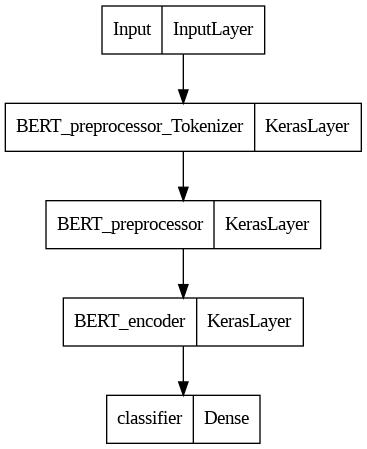

In [11]:
keras.utils.plot_model(classifier_model)

In [12]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessor_Tokenizer (K  (None, None, None)  0           ['Input[0][0]']                  
 erasLayer)                                                                                       
                                                                                                  
 BERT_preprocessor (KerasLayer)  {'input_type_ids':   0          ['BERT_preprocessor_Tokenizer[0][
                                (None, 60),                      0]']                             
                                 'input_word_ids':                                            

In [13]:
# Uploading the dataset

In [14]:
from google.colab import drive
import pandas as pd

In [15]:
# Mount Google drive to get the dataset from
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# Reading the dataset in pandas dataframe forme
df=pd.read_csv('/content/drive/MyDrive/datasets/Corona_NLP_train.csv',encoding='ISO-8859-1')
cm_samples=pd.read_csv('/content/drive/MyDrive/datasets/Corona_NLP_test.csv',encoding='ISO-8859-1')

In [17]:
# Observing the dataset
print(f'Columns names {df.columns.values}')
print(f'Dataframe shape {df.shape}')

Columns names ['UserName' 'ScreenName' 'Location' 'TweetAt' 'OriginalTweet' 'Sentiment']
Dataframe shape (41157, 6)


UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


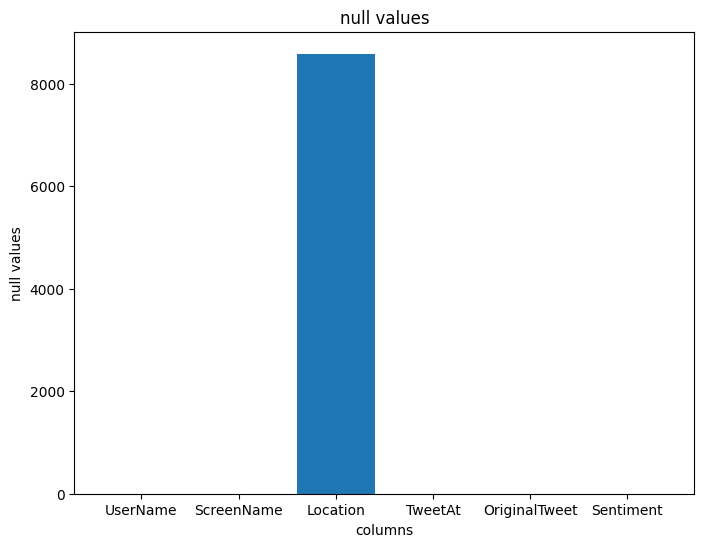

In [21]:
# Check missing values
missing_values=df.isnull().sum()
print (missing_values)
# Sample data for the x-axis categories and corresponding bar heights
categories = missing_values.index
bar_heights = missing_values.values

plt.figure(figsize=(8, 6))

# Plotting the vertical bars
plt.bar(categories, bar_heights)

# Optional: Customize the plot
plt.xlabel('columns')
plt.ylabel('null values')
plt.title('null values')

# Display the plot
plt.show()

In [23]:
# The cleaning function
import emoji
import re
def clean_text(text):
    # Step 1: Convert to lowercase
    text = text.lower()

    # Step 2: Remove URLs
    text = ' '.join(word for word in text.split() if not word.startswith('http'))

    # Step 3: Remove mentions (@) and hashtags (#)
    text = ' '.join(word for word in text.split() if not word.startswith('@') and not word.startswith('#'))

    # Step 4: Remove emojis
    text = emoji.replace_emoji(text, '')

    # Step 5: Handle abbreviations
    # Dictionary of English Contractions   from    https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
    abbreviations = {"bro": "brother", "luv":"love", "omg":" ", "lol":" ", "fyi":"for your information", "u": "you", "cuz": "because", "wanna": "want to", "gonna": "going to",
                "im": "i am", "id": "i would", "hes": "he is", "shes": "she is",
               "werent": "were not", "arent": "are not", "wasnt": "was not", "isnt": "is not", "didnt": "did not",
               "couldnt": "could not", "shouldnt": "should not", "wouldnt": "would not", "dont": "do not", "doesnt": "does not",
               "thats": "that is", "theres": "there is", "whats": "what is", "theyre": "they are",
               "cant": "can not", "hadnt": "had not", "havent": "have not",  "couldve": "could have",
               "shouldve": "should have", "wouldve": "would have", "dont": "do not", "doesnt": "does not", "didnt": "did not",
               "hasnt": "has not", "aint": "are not", "youve": "you have", "theyve": "they have", "weve": "we have", "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "i'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}
    text = ' '.join(abbreviations.get(word, word) for word in text.split())

    # Step 6: Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)

    # Step 7: Remove special characters and digits
    text = ''.join(char for char in text if char.isalnum() or char.isspace())

    # Step 8: Remove numbers
    text = ' '.join(word for word in text.split() if not word.isdigit())

    # Step 9: Remove extra whitespaces
    text = ' '.join(text.split())

    return text

In [47]:
# Deleting retweets
df = df.loc[~df['OriginalTweet'].str.startswith("RT @")]

In [51]:
# Cleaning the tweets
df['tweet']=df['OriginalTweet'].apply(clean_text)

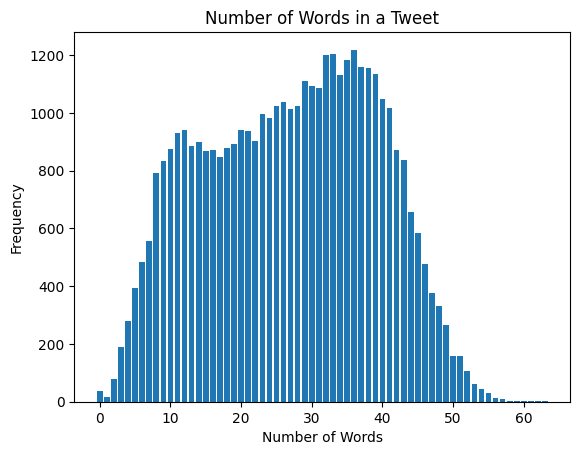

In [52]:
# Count the number of words in each tweet and store it in a new column
df['WordCount'] = df['tweet'].str.split().apply(len)

# Count the frequency of each word count
wordcount_counts = df['WordCount'].value_counts().sort_index()

# Plotting the vertical bars
plt.bar(wordcount_counts.index, wordcount_counts.values)

# Customize the plot
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words in a Tweet')

# Display the plot
plt.show()

In [45]:
# refine the classes
df['Sentiment'] = df['Sentiment'].replace({'Extremely Negative': 'negative',
                                                   'Negative': 'negative',
                                                   'Neutral': 'neutral',
                                                   'Positive': 'positive',
                                                   'Extremely Positive': 'positive'})

positive    18046
negative    15398
neutral      7713
Name: Sentiment, dtype: int64


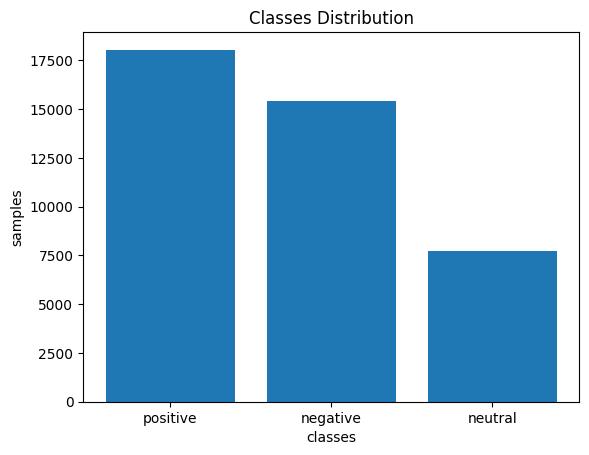

In [48]:
# Observe classes
classes=df['Sentiment'].value_counts()
print(classes)

# Sample data for the x-axis categories and corresponding bar heights
categories = classes.index
bar_heights = classes.values

# Plotting the vertical bars
plt.bar(categories, bar_heights)

# Optional: Customize the plot
plt.xlabel('classes')
plt.ylabel('samples')
plt.title('Classes Distribution')

# Display the plot
plt.show()

In [ ]:
# switch classes to numbered labels
df['Sentiment'] = df['Sentiment'].replace({'negative':2 , 'neutral':0, 'positive':1})

In [27]:
# Preform one-hot encoding to labels
from tensorflow.keras.utils import to_categorical
labels=to_categorical(df['Sentiment'])
label=pd.DataFrame(labels)

In [28]:
# Present the one-hot encoding
label.sample(5)

,0,1,2
187,1.0,0.0,0.0
2217,0.0,1.0,0.0
18029,1.0,0.0,0.0
37838,0.0,1.0,0.0
32086,0.0,0.0,1.0


In [29]:
#drop the unnecessary columns
df=df[['tweet']]

In [30]:
# Present the final data shape before feeding it to the model
df.sample(5)

,tweet
38461,glad to know sells fake hand sanitizer label s...
29805,for the past three weeks the fish exports from...
27318,this robot is helping people maintain a safe d...
10664,there are many people who are living below the...
519,uh what happens when a grocery store or delive...


In [31]:
# Compiling the model with the hyperparameters
classifier_model.compile(optimizer=keras.optimizers.Adam(2e-5),
              loss='CategoricalCrossentropy',
              metrics=['accuracy','Recall','Precision'])

In [32]:
# Train the model
history=classifier_model.fit(df['tweet'].astype(str),label.astype(int),epochs=3,batch_size=50,validation_split=0.2)

Epoch 1/3
659/659 [==============================] - 610s 847ms/step - loss: 0.5451 - accuracy: 0.7799 - recall: 0.7291 - precision: 0.8208 - val_loss: 0.3397 - val_accuracy: 0.8816 - val_recall: 0.8735 - val_precision: 0.8902
Epoch 2/3
659/659 [==============================] - 552s 837ms/step - loss: 0.2713 - accuracy: 0.9075 - recall: 0.8960 - precision: 0.9194 - val_loss: 0.2689 - val_accuracy: 0.9080 - val_recall: 0.8943 - val_precision: 0.9207
Epoch 3/3
659/659 [==============================] - 555s 842ms/step - loss: 0.1815 - accuracy: 0.9392 - recall: 0.9304 - precision: 0.9494 - val_loss: 0.2801 - val_accuracy: 0.9135 - val_recall: 0.9035 - val_precision: 0.9262


max result is loss: 0.6573 - accuracy: 0.6110 in head(1000) -------- after adding a hidden layer with 400 neurons we got 64

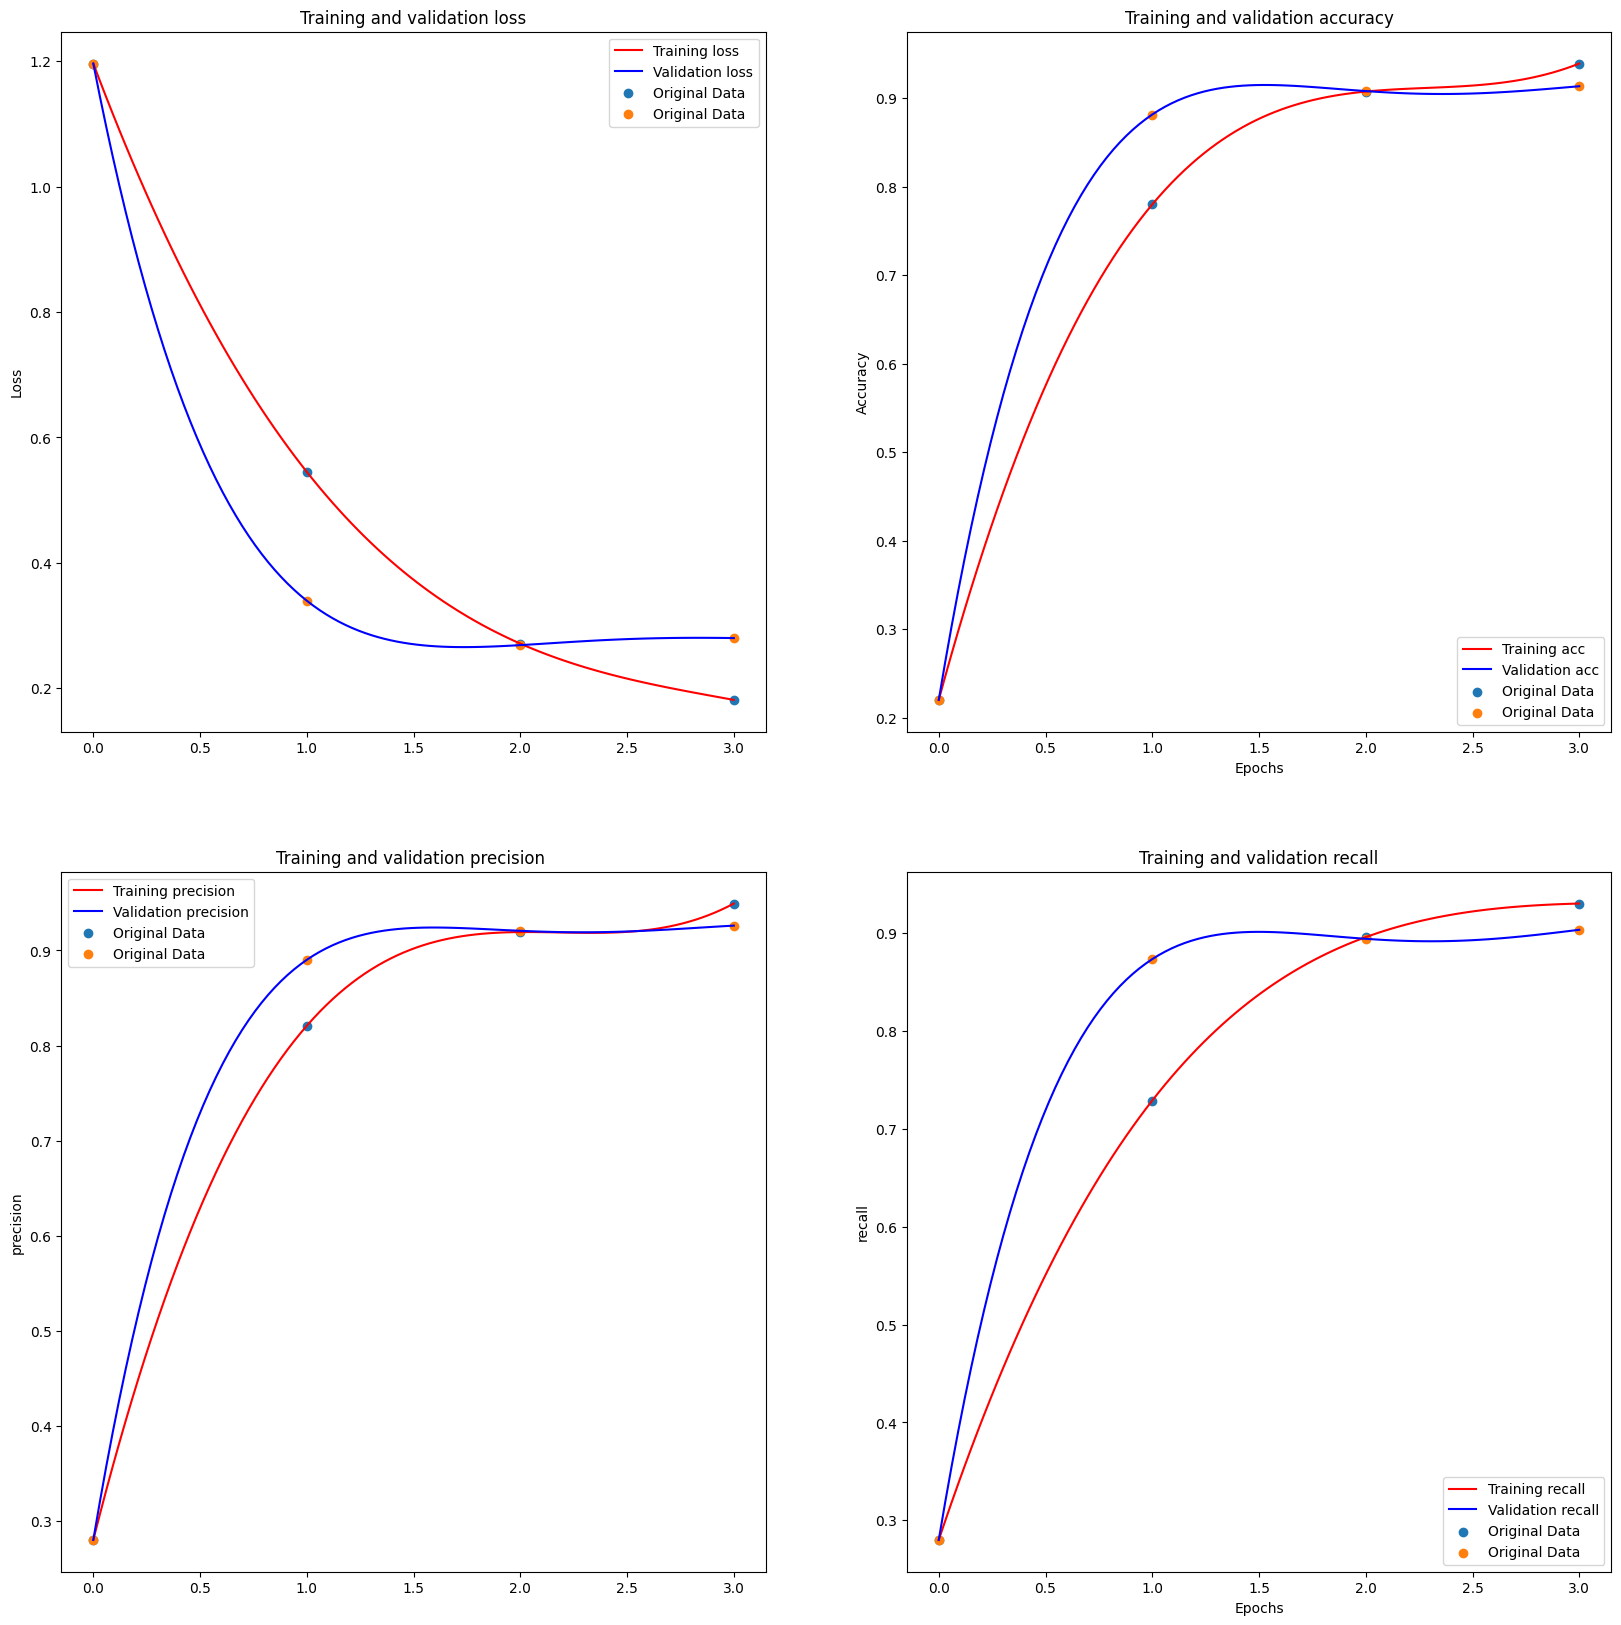

In [33]:
# Treating and presenting the training and validation results
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline

history_dict = history.history

# Organizing the results
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']



#adding the fist point that represent the performence of the model before training to make the first point in the evolution.
# These edded values are the reuslts of the BERT pure model without before fine-tunning. You are welcome to check these results on https://colab.research.google.com/drive/1zqwT5sS0leMceEpG7CX3KXhyvfeIHhCb?usp=sharing
# The purpose of this addition is to show the true evolution of the model during the training
acc.insert(0, 0.22)
val_acc.insert(0, 0.22)
loss.insert(0, 1.1961527)
val_loss.insert(0, 1.1961527)
precision.insert(0, 0.28)
val_precision.insert(0, 0.28)
recall.insert(0, 0.28)
val_recall.insert(0, 0.28)

# To adapt the plot to be analysable and more detailed we had to change dgree of spline attribute (k) to the fifth-degree spline curve.
# Since "UnivariateSpline" method obligate that k < n° x-values we had to duplicate the last point of each plot neededto spline with the fifth-degree curve.
val_acc.append(val_acc[3])
val_acc.append(val_acc[3])
val_loss.append(val_loss[3])
val_loss.append(val_loss[3])
val_precision.append(val_acc[3])
val_precision.append(val_acc[3])
val_recall.append(val_acc[3])
val_recall.append(val_acc[3])
recall.append(recall[3])
recall.append(recall[3])


#the number of epochs to plot
epochs = range(0, len(acc) )
#extended number of the x coordination on the plot in order to get the fifth-degree spline curve.
extended_epochs=[0,1,2,3,4,5]

# Create smoother lines using cubic spline interpolation
x_new = np.linspace(min(epochs), max(epochs), 100)

#acc smooth
smoother = UnivariateSpline(epochs, acc)
acc_smooth = smoother(x_new)

#loss smooth
smoother = UnivariateSpline(epochs, loss)
loss_smooth = smoother(x_new)

#val_loss smooth
smoother = UnivariateSpline(extended_epochs, val_loss,k=5)
val_loss_smooth = smoother(x_new)

#val_acc_smoother
smoother = UnivariateSpline(extended_epochs, val_acc,k=5)
val_acc_smooth = smoother(x_new)

#precision smooth
smoother = UnivariateSpline(epochs, precision)
precision_smooth = smoother(x_new)

#val_precision smooth
smoother = UnivariateSpline(extended_epochs, val_precision,k=5)
val_precision_smooth = smoother(x_new)

#recall smooth
smoother = UnivariateSpline(extended_epochs, recall,k=5)
recall_smooth = smoother(x_new)

#val_recall smooth
smoother = UnivariateSpline(extended_epochs, val_recall,k=5)
val_recall_smooth = smoother(x_new)

#plot
fig = plt.figure(figsize=(20, 20))
fig.tight_layout()

# loss subplot
plt.subplot(2, 2, 1)
plt.plot(x_new, loss_smooth, 'r', label='Training loss')
plt.plot(x_new, val_loss_smooth, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.scatter(epochs, loss, label='Original Data')
plt.scatter(epochs, val_loss[:4], label='Original Data')
plt.legend()

# accuracy subplot
plt.subplot(2, 2, 2)
plt.plot(x_new, acc_smooth, 'r', label='Training acc')
plt.plot(x_new, val_acc_smooth, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.scatter(epochs, acc, label='Original Data')
plt.scatter(epochs, val_acc[:4], label='Original Data')
plt.legend(loc='lower right')

# percision subplot
plt.subplot(2, 2, 3)
plt.plot(x_new, precision_smooth, 'r', label='Training precision')
plt.plot(x_new, val_precision_smooth, 'b', label='Validation precision')
plt.title('Training and validation precision ')
plt.ylabel('precision')
plt.scatter(epochs, precision, label='Original Data')
plt.scatter(epochs, val_precision[:4], label='Original Data')
plt.legend()

# recall subplot
plt.subplot(2, 2, 4)
plt.plot(x_new, recall_smooth, 'r', label='Training recall')
plt.plot(x_new, val_recall_smooth, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.ylabel('recall')
plt.xlabel('Epochs')
plt.scatter(epochs, recall[:4], label='Original Data')
plt.scatter(epochs, val_recall[:4], label='Original Data')
plt.legend(loc='lower right')

plt.show()


In [34]:
# In order of exporting the model
saved_model_path = '/content/drive/MyDrive/models/Classifier'
classifier_model.save(saved_model_path)

In [35]:
# Confusion matrix
# treating the confusion matrix samples
cm_samples['tweet']=cm_samples['OriginalTweet'].apply(clean_text)

cm_samples['Sentiment'] = cm_samples['Sentiment'].replace({'Extremely Negative': 'negative',
                                                   'Negative': 'negative',
                                                   'Neutral': 'neutral',
                                                   'Positive': 'positive',
                                                   'Extremely Positive': 'positive'})
cm_samples['Sentiment'] = cm_samples['Sentiment'].replace({'negative':2 , 'neutral':0, 'positive':1})

label=cm_samples['Sentiment']

In [39]:
# predicting the result of the confusion matrix samples with our model
predictions = classifier_model.predict(cm_samples['tweet'].astype(str))

119/119 [==============================] - 26s 189ms/step


In [40]:
# taking the higher probability result of the 3 classes as the result
predicted_labels = [np.argmax(i) for i in predictions]
predicted_labels[0]

2

In [41]:
# confusion matrix method
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

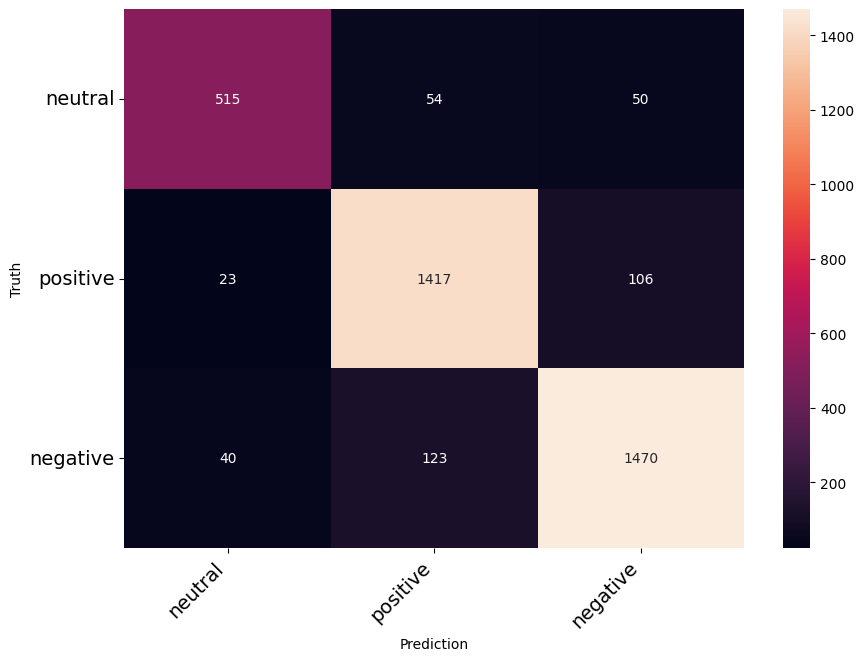

In [42]:
# creating the confusion matrix
cm = confusion_matrix(label,predicted_labels)
print_confusion_matrix(cm,["neutral","positive","negative"])